In [ ]:
%pip install --upgrade transformers datasets torch torchvision
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 838.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216

In [ ]:
import transformers
print(transformers.__version__)
from transformers import PreTrainedModel, BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, EarlyStoppingCallback
print("Imports OK")


4.53.0
Imports OK


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, set_seed, TrainingArguments, DataCollatorWithPadding
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import time
import os
import shutil

In [ ]:
df = pd.read_csv(r'/content/preprocessed.csv')
# Eliminar filas sin etiqueta y convertir 'Label' a string
df = df[df['Label'].notna()].copy()
df['Label'] = df['Label'].astype(str)
# Unificar nombre de la columna de texto si viene como 'Text'
if 'Text' in df.columns:
    df.rename(columns={'Text': 'text'}, inplace=True)

# Mapear etiquetas a IDs y renombrar columna a 'labels'
label_list = sorted(df['Label'].unique())
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}
df['labels'] = df['Label'].map(label2id)

# Mostrar distribución de etiquetas
print("Distribución de etiquetas:")
print(df['labels'].value_counts())


Distribución de etiquetas:
labels
0    200
1    200
2    200
3    200
Name: count, dtype: int64


In [ ]:
# 2. División train/test/val
df_trainval, df_test = train_test_split(
    df[['text', 'labels']],
    test_size=0.1,
    stratify=df['labels'],
    random_state=42

)
# Ahora dividir el 90% restante en 70/20
df_train, df_val = train_test_split(
    df_trainval,
    test_size=2/9,
    stratify=df_trainval['labels'],
    random_state=42
)
train_ds = Dataset.from_pandas(df_train)
val_ds   = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)

In [ ]:
# 3. Tokenización con BERT
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=300)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [ ]:
# 4. Definir modelo de clasificación con BERT
def model_init():
    return BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id
    )

In [ ]:
# 5. Data collator y métricas
data_collator = DataCollatorWithPadding(tokenizer)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'f1_macro': f1_score(p.label_ids, preds, average='macro')
    }

In [ ]:
# submuestra
small_train_ds = train_ds.shuffle(seed=42).select(range(200))
small_eval_ds = test_ds.shuffle(seed=42).select(range(80))

In [ ]:
# 6. Configuración de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    logging_steps=50,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    report_to="none"
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=small_train_ds,
    eval_dataset=small_eval_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

/tmp/ipython-input-13-209981554.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimización con Optuna
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=5,  # se puede subir esto más tarde
    hp_space=lambda trial: {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3)
    },
    compute_objective=lambda metrics: metrics["eval_f1_macro"]
)

print("Mejores hiperparámetros encontrados:", best_trial)


[I 2025-06-30 11:32:17,591] A new study created in memory with name: no-name-488870f3-3b5b-47bc-8a72-ea5369052376
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.357835,0.312500,0.208824
2,1.313800,1.156179,0.587500,0.568404
3,1.313800,1.010200,0.550000,0.514615


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument i

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.338097,0.362500,0.251984
2,1.267500,1.056091,0.600000,0.570311
3,1.267500,0.921040,0.637500,0.617469


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument i

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.399313,0.250000,0.100000
2,No log,1.369801,0.325000,0.283673
3,No log,1.357709,0.362500,0.354296


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument i

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.364902,0.362500,0.274870
2,1.357100,1.296431,0.450000,0.438298
3,1.357100,1.237928,0.462500,0.431322


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument i

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.391683,0.250000,0.100000
2,No log,1.366965,0.312500,0.297748


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-06-30 14:37:57,849] Trial 4 finished with value: 0.2977477477477477 and parameters: {'learning_rate': 3.875316910971948e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.09401866282046341}. Best is trial 1 with value: 0.6174686716791981.


Mejores hiperparámetros encontrados: BestRun(run_id='1', objective=0.6174686716791981, hyperparameters={'learning_rate': 4.850093544228977e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.07103740046273502}, run_summary=None)


In [ ]:
# Reentrenar con mejores hiperparámetros
best_args = TrainingArguments(
    output_dir='./results_best',
    learning_rate=best_trial.hyperparameters['learning_rate'],
    per_device_train_batch_size=best_trial.hyperparameters['per_device_train_batch_size'],
    per_device_eval_batch_size=best_trial.hyperparameters['per_device_train_batch_size'],
    num_train_epochs=best_trial.hyperparameters['num_train_epochs'],
    weight_decay=best_trial.hyperparameters['weight_decay'],
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=50,
    do_train=True,
    do_eval=True,
    report_to="none"
)

# Nuevo trainer con los mejores hiperparámetros
best_trainer = Trainer(
    model_init=model_init,
    args=best_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-14-3843580200.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 7. Entrenamiento y evaluación

best_trainer.train()

# Evaluación final
metrics = best_trainer.evaluate()
print("RESULTADOS VALIDACIÓN FINAL:\n", metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.312700,0.824634,0.675000,0.650637
2,0.828000,0.617100,0.787500,0.777793
3,0.347300,0.641775,0.750000,0.747752


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


RESULTADOS VALIDACIÓN FINAL:
 {'eval_loss': 0.6171002388000488, 'eval_accuracy': 0.7875, 'eval_f1_macro': 0.7777934140163243, 'eval_runtime': 84.598, 'eval_samples_per_second': 0.946, 'eval_steps_per_second': 0.118, 'epoch': 3.0}


In [ ]:
predictions = best_trainer.predict(test_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                   precision    recall  f1-score   support

 drug and alcohol       0.83      1.00      0.91        20
       early life       0.75      0.90      0.82        20
      personality       0.79      0.55      0.65        20
trauma and stress       0.78      0.70      0.74        20

         accuracy                           0.79        80
        macro avg       0.79      0.79      0.78        80
     weighted avg       0.79      0.79      0.78        80



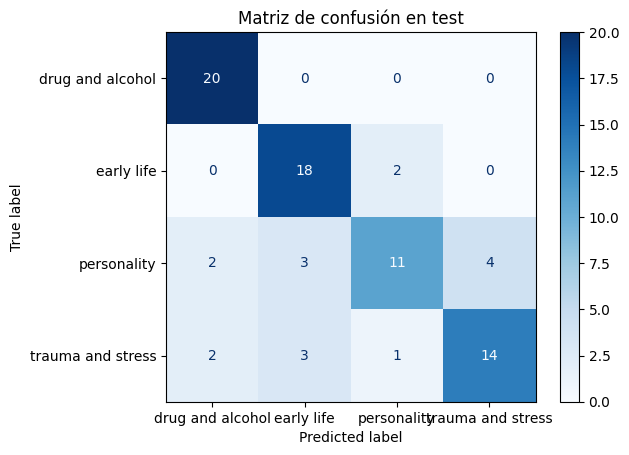

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Etiquetas reales y predichas
print(classification_report(labels, preds, target_names=label_list))

# Matriz de confusión
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión en test")
plt.show()

In [ ]:
#Evaluación del tiempo
import torch
sample_texts = df_test['text'].sample(50, random_state=42).tolist()

start = time.time()
for text in sample_texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        best_trainer.model(**inputs)
end = time.time()

tiempo_prom = (end - start) / len(sample_texts)
print(f"Tiempo medio por predicción: {tiempo_prom:.4f} segundos")

Tiempo medio por predicción: 2.4666 segundos


In [ ]:
SAVE_FINAL = False

In [ ]:
ckpt_dir = "./results"

In [ ]:
if SAVE_FINAL:

    trainer.save_model("./results")
    tokenizer.save_pretrained("./results")


    final_model     = AutoModelForSequenceClassification.from_pretrained("./results")
    final_tokenizer = AutoTokenizer.from_pretrained("./results")

    BASE_DIR   = os.path.dirname(__file__)
    deploy_dir = os.path.join(BASE_DIR, "api", "model")


    if os.path.isdir(deploy_dir):
        shutil.rmtree(deploy_dir)
    os.makedirs(deploy_dir, exist_ok=True)


    final_model.save_pretrained(deploy_dir)
    final_tokenizer.save_pretrained(deploy_dir)
    print(f"Modelo final guardado en {deploy_dir}")